In [3]:
# @title
!pip install python-chess
!pip install ipywidgets
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=f7c60f42a61e0c31db77773bebfa5c8732163034eaffac5925bae98549e22f44
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.6 MB/s eta 0:00:00


In [1]:
# @title
!wget https://archive.org/download/stockfish14/stockfish_14_linux_x64_popcnt.zip
!unzip stockfish_14_linux_x64_popcnt.zip

--2024-11-30 23:39:23--  https://archive.org/download/stockfish14/stockfish_14_linux_x64_popcnt.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia804504.us.archive.org/7/items/stockfish14/stockfish_14_linux_x64_popcnt.zip [following]
--2024-11-30 23:39:23--  https://ia804504.us.archive.org/7/items/stockfish14/stockfish_14_linux_x64_popcnt.zip
Resolving ia804504.us.archive.org (ia804504.us.archive.org)... 207.241.235.74
Connecting to ia804504.us.archive.org (ia804504.us.archive.org)|207.241.235.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28531469 (27M) [application/zip]
Saving to: ‘stockfish_14_linux_x64_popcnt.zip’

stockfish_14_linux_ 100%[===================>]  27.21M  47.5MB/s    in 0.6s    

2024-11-30 23:39:24 (47.5 MB/s) - ‘stockfish_14_linux_x64_popcnt.zip’ saved [28531469/28531469]

Archive:  stock

In [77]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, entropy
import chess
import chess.engine
import chess.svg
from IPython.display import SVG, display, clear_output
import ipywidgets as widgets
from scipy.interpolate import interp1d

# Mapping of Elo to centipawn loss mean and std dev
elo_ranges = {
    560: (170, 85),
    690: (150, 75),
    760: (140, 70),
    840: (130, 65),
    930: (120, 60),
    1030: (110, 55),
    1140: (100, 50),
    1260: (90, 45),
    1390: (80, 40),
    1540: (70, 35),
    1700: (60, 30),
    1880: (50, 25),
    2080: (40, 20),
    2300: (30, 15),
    2540: (20, 10),
    2800: (10, 5),
}

stockfish_path = "stockfish_14_linux_x64_popcnt/stockfish_14_x64_popcnt"

engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

prior_interpolated = interp1d(elo_values, prior, kind="linear", fill_value="extrapolate")

In [78]:
# @title
def centipawn_loss_likelihood(centipawn_loss):
    """Compute the likelihood of observing the given centipawn loss at various Elo ratings."""
    likelihood = np.zeros_like(elo_values)

    for elo, (mean_loss, std_dev) in elo_ranges.items():
        elo_likelihood = norm.pdf(elo_values, loc=elo, scale=200)
        loss_likelihood = norm.pdf(centipawn_loss, loc=mean_loss, scale=std_dev)
        likelihood += prior_interpolated(elo) * elo_likelihood * loss_likelihood

    return likelihood

def update_posterior(prior, likelihood):
    """Update the posterior distribution using Bayes' theorem."""
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    return posterior

def check_confidence(posterior, elo_values, confidence=0.5, margin=100):
    """Check if the engine is confident about the player's Elo."""
    cdf = np.cumsum(posterior)
    low_idx = np.argmax(cdf >= (1 - confidence) / 2)
    high_idx = np.argmax(cdf >= (1 + confidence) / 2)

    low_elo = elo_values[low_idx]
    high_elo = elo_values[high_idx]

    if high_elo - low_elo <= 2 * margin:
        return True, (low_elo + high_elo) / 2
    return False, None

def calculate_information_gain(move):
    """Calculate the expected information gain for a move, weighted by current belief."""
    board.push(move)

    # Get the engine's evaluation after the move
    info_after = engine.analyse(board, chess.engine.Limit(time=0.5))
    eval_after = info_after["score"].relative

    if eval_after.is_mate():
        board.pop()
        return 0

    centipawn_loss = eval_after.score(mate_score=10000)
    likelihood = centipawn_loss_likelihood(centipawn_loss)

    # Update posterior distribution for this move
    posterior = update_posterior(prior, likelihood)

    # Calculate information gain, weighted by current belief
    prior_entropy = entropy(prior)
    posterior_entropy = entropy(posterior)
    info_gain = prior_entropy - posterior_entropy

    # Scale the information gain by how well it aligns with the current belief
    alignment_weight = np.sum(prior * likelihood)
    weighted_info_gain = info_gain * alignment_weight

    board.pop()
    return weighted_info_gain

def handle_player_move(button):
    global prior
    move = move_input.value.strip()
    move_input.value = ""
    try:
        chess_move = board.parse_san(move)  # Parse algebraic notation
        if chess_move in board.legal_moves:
            # Get evaluation before making the move
            info_before = engine.analyse(board, chess.engine.Limit(time=3))
            best_move = info_before["pv"][0]  # Principal variation (best move sequence)
            best_move_san = board.san(best_move)

            board.push(best_move)
            info_then = engine.analyse(board, chess.engine.Limit(time=1.5))
            eval_before = info_then["score"].relative
            board.pop()

            # Make the player's move
            board.push(chess_move)
            display_board()

            # Check if the game is over after the player's move
            if board.is_game_over():
                check_game_status()
                return  # Stop if the game is over

            # Get evaluation after the player's move
            info_after = engine.analyse(board, chess.engine.Limit(time=0.5))
            eval_after = info_after["score"].relative

            # Calculate centipawn loss
            if eval_before.is_mate() or eval_after.is_mate():
                print(f"Best move was: {best_move_san}")
                print("Centipawn loss: N/A (mate)")
            else:
                if (eval_before.score(mate_score=10000) - eval_after.score(mate_score=10000)) > 0:
                    centipawn_loss = 0
                else:
                    centipawn_loss = eval_after.score(mate_score=10000) - eval_before.score(mate_score=10000)
                print(f"Centipawn loss for your move: {centipawn_loss}")
                print(f"Best move was: {best_move_san}")

                # Update posterior distribution based on this move's centipawn loss
                likelihood = centipawn_loss_likelihood(centipawn_loss)
                prior = update_posterior(prior, likelihood)

                # Plot the updated distribution
                plt.figure(figsize=(10, 6))
                plt.plot(elo_values, prior, label=f"Updated after centipawn loss: {centipawn_loss}")
                plt.title("Updated Elo Probability Distribution")
                plt.xlabel("Elo Rating")
                plt.ylabel("Probability")
                plt.grid()
                plt.legend()
                plt.show()

                # Check stopping condition
                is_confident, predicted_elo = check_confidence(prior, elo_values)
                if is_confident:
                    print(f"Engine is 50% confident your Elo is approximately {predicted_elo:.0f} ± 100.")
                    return

            # If the game is not over, allow the engine to play its move
            handle_engine_move()
        else:
            print("Illegal move. Try again.")
    except Exception as e:
        print(f"Invalid input: {e}")

def handle_engine_move():
    with output:
        print("Stockfish is thinking...")
    legal_moves = list(board.legal_moves)
    best_move = None
    max_info_gain = -np.inf

    for move in legal_moves:
        info_gain = calculate_information_gain(move)
        if info_gain > max_info_gain:
            max_info_gain = info_gain
            best_move = move

    # Push the engine's move
    engine_move = board.san(best_move)
    print(f"Stockfish played: {engine_move}")
    board.push(best_move)
    display_board()

    # Check if the game is over after the engine's move
    if board.is_game_over():
        check_game_status()
        return  # Stop if the game is over

def check_game_status():
    """Check the game status and display the result, including predicted Elo."""
    if board.is_checkmate():
        print("Checkmate! Game over.")
    elif board.is_stalemate():
        print("Stalemate! It's a draw.")
    elif board.is_insufficient_material():
        print("Draw due to insufficient material.")
    else:
        return  # If the game isn't over, return early

    # Calculate the most likely Elo and confidence
    max_probability = max(prior)
    predicted_elo = elo_values[np.argmax(prior)]
    confidence = max_probability * 100  # Convert to percentage

    print(f"Predicted Elo: {predicted_elo:.0f}")
    print(f"Confidence in prediction: {confidence:.2f}%")

def display_board():
    with output:
        clear_output(wait=True)
        display(SVG(chess.svg.board(board=board, size=300)))

Centipawn loss for your move: 0
Best move was: d4


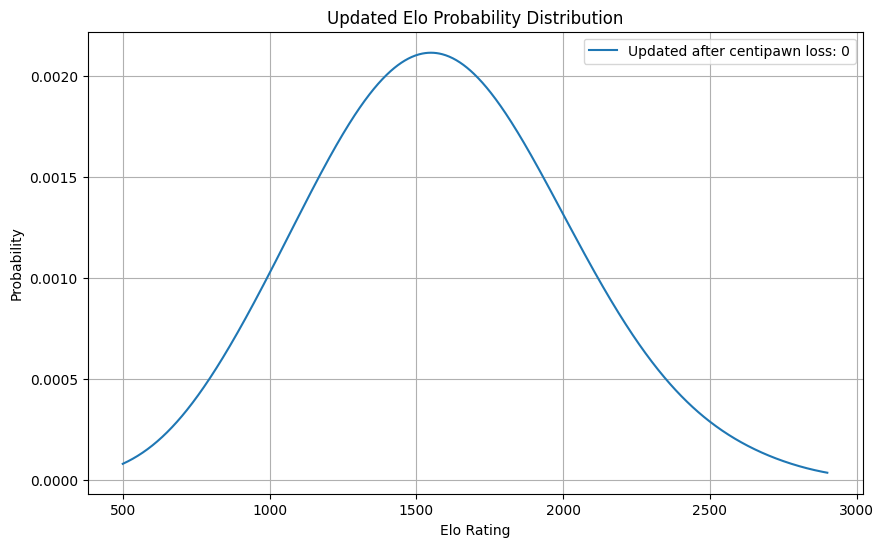

Stockfish played: a6


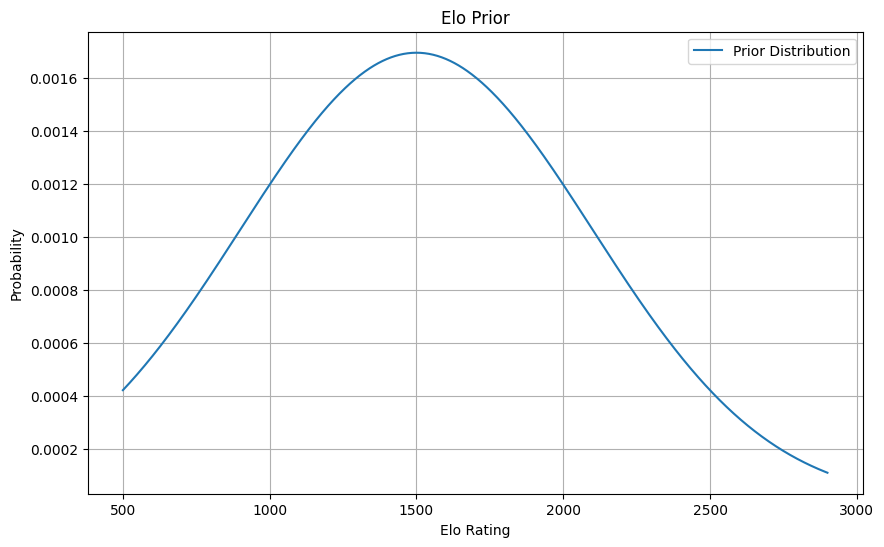

Centipawn loss for your move: 0
Best move was: d4


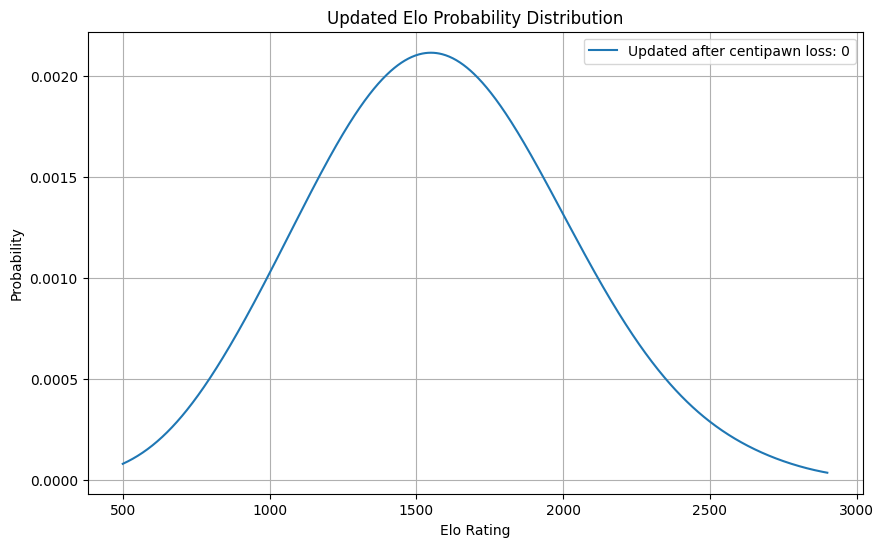

Stockfish played: g6
Centipawn loss for your move: 4
Best move was: e4


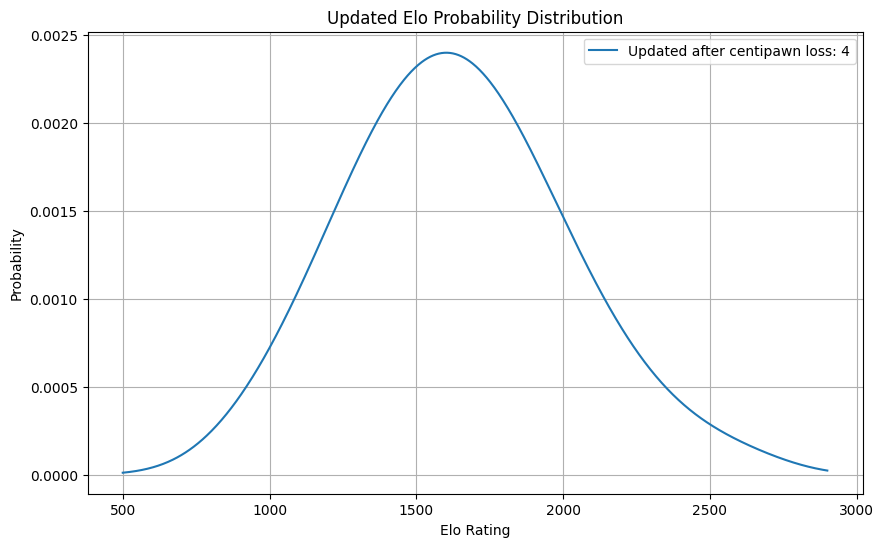

Stockfish played: Bg7
Centipawn loss for your move: 0
Best move was: Nc3


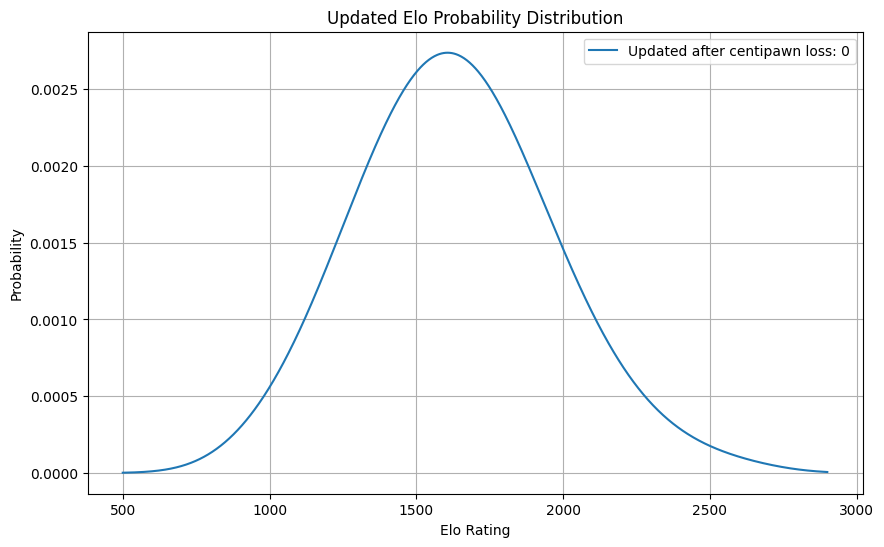

Stockfish played: d6
Centipawn loss for your move: 12
Best move was: Nc3


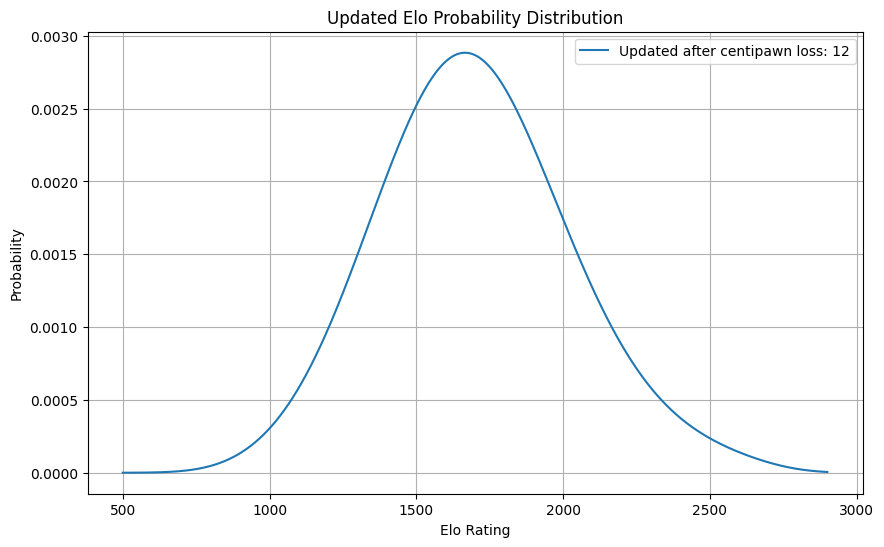

Stockfish played: Nf6
Centipawn loss for your move: 1
Best move was: O-O


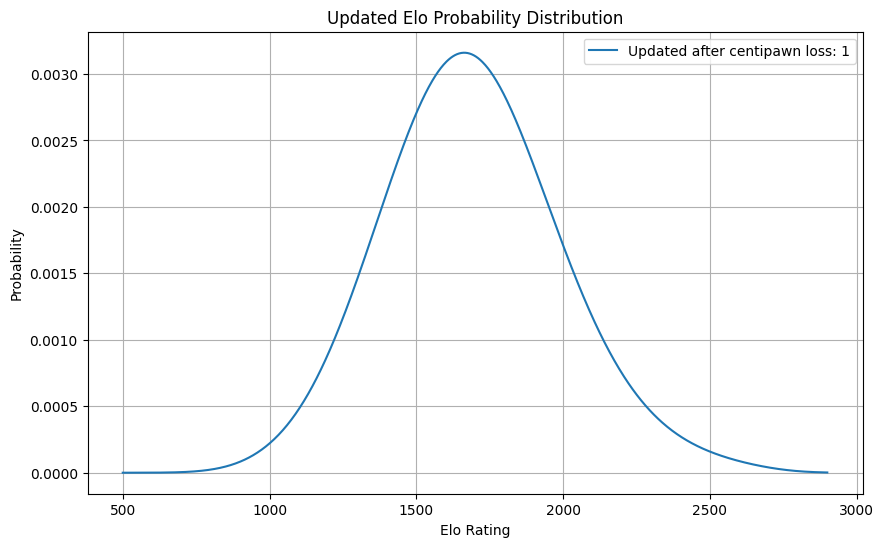

Stockfish played: c5


In [80]:
# @title
# Initialize a chess board
board = chess.Board()

output = widgets.Output()
move_input = widgets.Text(placeholder="Enter your move")
submit_button = widgets.Button(description="Submit Move")
result_label = widgets.Label()

move_input.on_submit(handle_player_move)
submit_button.on_click(handle_player_move)

display_board()
display(widgets.VBox([output, move_input, submit_button, result_label]))

mean_elo = 1500  # Average Elo
std_dev_elo = 600  # Standard deviation

# Compute the real-world prior
prior = norm.pdf(elo_values, loc=mean_elo, scale=std_dev_elo)
prior /= np.sum(prior)

plt.figure(figsize=(10, 6))
plt.plot(elo_values, prior, label="Prior Distribution")
plt.title("Elo Prior")
plt.xlabel("Elo Rating")
plt.ylabel("Probability")
plt.grid()
plt.legend()
plt.show()

In [81]:
!pip install nbconvert
